### Importação das Bibliotecas

In [1]:
# Importação das bibliotecas
import random
import numpy as np
import matplotlib.pyplot as plt

### Modelagem de Dados

In [2]:
# Funcionários
funcionarios = [
    {"id": 1, "nome": "Ana", "preferencias_folga": ["domingo"]},
    {"id": 2, "nome": "Bruno", "preferencias_folga": ["sábado"]},
    {"id": 3, "nome": "Carla", "preferencias_folga": ["segunda"]},
    {"id": 4, "nome": "Diego", "preferencias_folga": ["terça"]},
    {"id": 5, "nome": "Elisa", "preferencias_folga": ["quarta"]},
    {"id": 6, "nome": "Felipe", "preferencias_folga": ["sexta"]},
]

# Dias e turnos
semana = ["segunda", "terça", "quarta", "quinta", "sexta", "sábado", "domingo"]
turnos = ["manha", "tarde", "noite"]

### Restrições

In [3]:
CARGA_MAX_SEMANAL = 6  # máximo de turnos por semana por funcionário
FOLGAS_OBRIGATORIAS = 1  # mínimo de folgas por semana
COBERTURA_MINIMA = 2  # mínimo de funcionários por turno

def checar_restricoes(escala, funcionarios, semana, turnos):
    violacoes = []
    # 1. Carga horária máxima e folgas obrigatórias
    for f in funcionarios:
        total_turnos = sum(escala[f["id"]][dia][turno] for dia in semana for turno in turnos)
        folgas = sum(all(escala[f["id"]][dia][t] == 0 for t in turnos) for dia in semana)
        if total_turnos > CARGA_MAX_SEMANAL:
            violacoes.append(f"{f['nome']} excedeu carga máxima semanal.")
        if folgas < FOLGAS_OBRIGATORIAS:
            violacoes.append(f"{f['nome']} não tem folgas suficientes.")
    # 2. Cobertura mínima por turno
    for dia in semana:
        for turno in turnos:
            trabalhando = sum(escala[f["id"]][dia][turno] for f in funcionarios)
            if trabalhando < COBERTURA_MINIMA:
                violacoes.append(f"Cobertura insuficiente em {dia} {turno}.")
    return violacoes

### Implementação do Algoritimo Genético

Número de violações encontradas: 3
 - Carla excedeu carga máxima semanal.
 - Elisa excedeu carga máxima semanal.
 - Felipe excedeu carga máxima semanal.


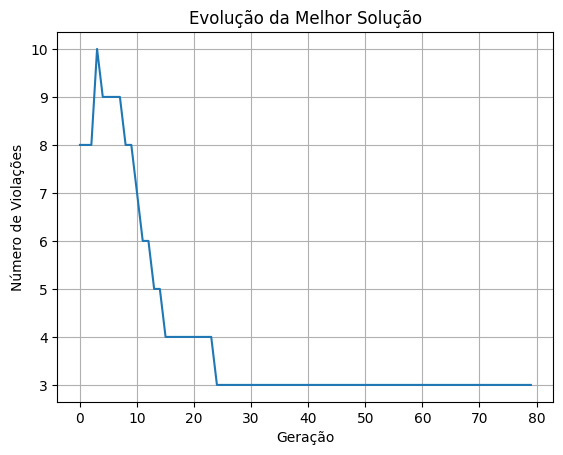

In [4]:
# Parâmetros do algoritmo genético
USAR_ELITISMO = False  # Se True, mantém o melhor indivíduo de cada geração
POP_SIZE = 20
N_GERACOES = 80
TAXA_MUTACAO = 0.2

# Geração de individuo aleatório (escala de trabalho)
def gerar_individuo(funcionarios, semana, turnos):
    escala = {f["id"]: {dia: {turno: 0 for turno in turnos} for dia in semana} for f in funcionarios}
    for f in funcionarios:
        dias_trabalhados = random.sample(semana, CARGA_MAX_SEMANAL)
        for dia in dias_trabalhados:
            turno = random.choice(turnos)
            escala[f["id"]][dia][turno] = 1
    return escala

# Avaliação do indivíduo (número de violações)
def avaliar_individuo(individuo, funcionarios, semana, turnos):
    violacoes = checar_restricoes(individuo, funcionarios, semana, turnos)
    return len(violacoes)

# Seleção de pais (torneio)
def selecionar_pais(populacao, funcionarios, semana, turnos):
    pais = []
    for _ in range(2):
        torneio = random.sample(populacao, 3)
        melhor = min(torneio, key=lambda ind: avaliar_individuo(ind, funcionarios, semana, turnos))
        pais.append(melhor)
    return pais

# Cruzamento de pais - Versão refatorada
def cruzar_pais(pai1, pai2):
    """
    Gera um filho combinando características dos dois pais.
    Cada posição da escala é herdada aleatoriamente de um dos pais.
    """
    filho = {}
    
    for funcionario_id in pai1.keys():
        filho[funcionario_id] = {}
        
        for dia in pai1[funcionario_id].keys():
            filho[funcionario_id][dia] = {}
            
            for turno in pai1[funcionario_id][dia].keys():
                # Escolha aleatória entre os pais
                pai_escolhido = pai1 if random.random() < 0.5 else pai2
                filho[funcionario_id][dia][turno] = pai_escolhido[funcionario_id][dia][turno]
    
    return filho

# Mutação do indivíduo
def mutar_individuo(individuo, funcionarios, semana, turnos):
    for f in funcionarios:
        if random.random() < TAXA_MUTACAO:
            dia = random.choice(semana)
            turno = random.choice(turnos)
            if individuo[f["id"]][dia][turno] == 1:
                individuo[f["id"]][dia][turno] = 0  # Remove o turno
            else:
                individuo[f["id"]][dia][turno] = 1  # Adiciona o turno
    return individuo

# Inicialização da população
populacao = [gerar_individuo(funcionarios, semana, turnos) for _ in range(POP_SIZE)]

# Evolução da população
melhores_geracoes = []
for geracao in range(N_GERACOES):
    nova_populacao = []
    
    # Avaliar e ordenar a população
    populacao_ordenada = sorted(populacao, key=lambda ind: avaliar_individuo(ind, funcionarios, semana, turnos), reverse=False)
    
    # Manter o melhor indivíduo se elitismo for usado
    if USAR_ELITISMO:
        nova_populacao.append(populacao_ordenada[0])
    
    # Seleção e cruzamento
    while len(nova_populacao) < POP_SIZE:
        pai1, pai2 = selecionar_pais(populacao_ordenada, funcionarios, semana, turnos)             
        filho = cruzar_pais(pai1, pai2)        
        filho = mutar_individuo(filho, funcionarios, semana, turnos)
        nova_populacao.append(filho)
    
    populacao = nova_populacao
    melhores_geracoes.append(populacao_ordenada[0])

# Avaliação da melhor escala encontrada
melhor_individuo = min(melhores_geracoes, key=lambda ind: avaliar_individuo(ind, funcionarios, semana, turnos))
# print("Melhor escala encontrada:")
# for f in funcionarios:
#     print(f"{f['nome']}: ", end="")
#     for dia in semana:
#         for turno in turnos:
#             if melhor_individuo[f["id"]][dia][turno] == 1:
#                 print(f"{dia} {turno}, ", end="")
#     print()

# Verificação das restrições na melhor escala
violacoes = checar_restricoes(melhor_individuo, funcionarios, semana, turnos)
if violacoes:
    print(f"Número de violações encontradas: {len(violacoes)}")
    for v in violacoes:
        print(f" - {v}")
else:
    print("✅ Nenhuma violação encontrada! Escala válida.")

# Plotando a evolução da melhor solução
melhores_aval = [avaliar_individuo(ind, funcionarios, semana, turnos) for ind in melhores_geracoes]
plt.plot(melhores_aval)
plt.title("Evolução da Melhor Solução")
plt.xlabel("Geração")
plt.ylabel("Número de Violações")
plt.grid()
plt.show()